# Ensemble NMS - Detectron2 [Inference]

### Hi kagglers, This is `Ensemble NMW - Detectron2 [Inference]` notebook.
* [Sartorius Segmentation - Detectron2 [training]](https://www.kaggle.com/ammarnassanalhajali/sartorius-segmentation-detectron2-training) 
* [Sartorius Segmentation - Detectron2 [Inference]](https://www.kaggle.com/ammarnassanalhajali/sartorius-segmentation-detectron2-inference) 
* [K-fold CrossValidation COCO Dataset Generator](https://www.kaggle.com/ammarnassanalhajali/k-fold-crossvalidation-coco-dataset-generator) 


### Please if this kernel is useful, <font color='red'>please upvote !!</font>

## Other notebooks in this competition 
- [Sartorius Segmentation - Keras U-Net[Training]](https://www.kaggle.com/ammarnassanalhajali/sartorius-segmentation-keras-u-net-training)
- [Sartorius Segmentation - Keras U-Net[Inference]](https://www.kaggle.com/ammarnassanalhajali/sartorius-segmentation-keras-u-net-inference/edit)

# Intro
Ensembling multiple weaker performing models can help to get the results that you want.

## Install and import libraries

In [1]:
!pip install ../input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/antlr4-python3-runtime-4.8/antlr4-python3-runtime-4.8 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/detectron2-0.5/detectron2 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/ensemble-boxes-104/ensemble_boxes-1.0.4/ -f ./ --no-index

Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272231 sha256=39c57ff589de6e27e26c829459c746de31ebe15c2a1d2a8ac217a6c42460aa4d
  Stored in directory: /root/.cache/pip/wheels/d2/09/29/2054c6cc4599cf39f1c52ce3c20bfb50be696caa5d5ba460c9
Successfully built pycocotools
Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
Processing /kaggle/in

In [2]:
import os
import cv2
import json
import time
import numpy as np
import pandas as pd
import torch
import detectron2
from tqdm.auto import tqdm
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import inference_on_dataset
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.data import DatasetCatalog, build_detection_test_loader
import pycocotools.mask as mask_util
from PIL import Image
import matplotlib.pyplot as plt
from fastcore.all import *
from ensemble_boxes import *
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print('GPU is available')
else:
    DEVICE = torch.device('cpu')
    print('CPU is used')
print('detectron ver:', detectron2.__version__)

GPU is available
detectron ver: 0.5


## My Models

In [3]:
# best_model=(
#     {'file': '/kaggle/input/gyy-sartoriusmodels/model_final_11.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.306,'ths':[.18, .38, .58]},
#     {'file': '/kaggle/input/sartorius-transfer-learning-model/model_0009679.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.300,'ths':[.18, .38, .58]},
# #     {'file': '/kaggle/input/gyy-sartoriusmodels/model_best_5.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.296,'ths':[.15, .35, .55]},
#     {'file': '/kaggle/input/gyy-sartoriusmodels/model_final_7.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.305,'ths':[.18, .38, .58]},
#     {'file': '/kaggle/input/gyy-sartoriusmodels/model_best_9.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.303,'ths':[.19, .39, .57]}

#             )

In [4]:
best_model=(
    {'file': '/kaggle/input/gyy-sartoriusmodels/model_final_11.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.306,'ths':[.18, .38, .58]},
    {'file': '/kaggle/input/sartorius-transfer-learning-model/model_0009679.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.300,'ths':[.18, .38, .58]},
#     {'file': '/kaggle/input/gyy-sartoriusmodels/model_best_5.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.296,'ths':[.15, .35, .55]},
    {'file': '/kaggle/input/gyy-sartoriusmodels/model_final_7.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.305,'ths':[.18, .38, .58]},
    {'file': '/kaggle/input/gyy-sartoriusmodels/model_best_9.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.303,'ths':[.19, .39, .57]},
    {'file': '/kaggle/input/gyy-sartoriusmodels/model_final_6.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.307,'ths':[.21, .39, .57]},
#     {'file': '/kaggle/input/gyy-sartoriusmodels/model_best_6.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.303,'ths':[.19, .39, .57]},
#     {'file': '/kaggle/input/gyy-sartoriusmodels/model_final_5.pth','config_name':'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', 'LB score': 0.303,'ths':[.19, .39, .57]}

            )

In [5]:
#config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
mdl_path = ""
DATA_PATH = "../input/sartorius-cell-instance-segmentation"
MODELS = []
BEST_MODELS =[]
THSS = []
ID_TEST = 0
SUBM_PATH = f'{DATA_PATH}/test'
SINGLE_MODE = False
NMS = True
MIN_PIXELS = [75, 150, 75]
IOU_TH = 0.3
for b_m in best_model:
    model_name=b_m["file"]
    model_ths=b_m["ths"]
    config_name=b_m["config_name"]
    BEST_MODELS.append(model_name)
    THSS.append(model_ths)
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_name))
    cfg.INPUT.MASK_FORMAT = 'bitmask'
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
    cfg.MODEL.WEIGHTS = f'{mdl_path}/{model_name}'  
    cfg.TEST.DETECTIONS_PER_IMAGE = 1000
    MODELS.append(DefaultPredictor(cfg))
print(f'all loaded:\nthresholds: {THSS}\nmodels: {BEST_MODELS}')

all loaded:
thresholds: [[0.18, 0.38, 0.58], [0.18, 0.38, 0.58], [0.18, 0.38, 0.58], [0.19, 0.39, 0.57], [0.21, 0.39, 0.57]]
models: ['/kaggle/input/gyy-sartoriusmodels/model_final_11.pth', '/kaggle/input/sartorius-transfer-learning-model/model_0009679.pth', '/kaggle/input/gyy-sartoriusmodels/model_final_7.pth', '/kaggle/input/gyy-sartoriusmodels/model_best_9.pth', '/kaggle/input/gyy-sartoriusmodels/model_final_6.pth']


In [6]:
MODELS

## Utils

In [7]:
def rle_decode(mask_rle, shape=(520, 704)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) 
                       for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def pred_masks(file_name, path, model, ths, min_pixels):
    img = cv2.imread(f'{path}/{file_name}')
    output = model(img)
    pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
    pred_class = max(set(pred_classes), key=pred_classes.count)
    take = output['instances'].scores >= ths[pred_class]
    pred_masks = output['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    result = []
    used = np.zeros(img.shape[:2], dtype=int) 
    for i, mask in enumerate(pred_masks):
        mask = mask * (1 - used)
        if mask.sum() >= min_pixels[pred_class]:
            used += mask
            result.append(rle_encode(mask))
    return result

def ensemble_preds(file_name, path, models, ths):
    img = cv2.imread(f'{path}/{file_name}')
    classes = []
    scores = []
    bboxes = []
    masks = []
    for i, model in enumerate(models):
        output = model(img)
        pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
        pred_class = max(set(pred_classes), key=pred_classes.count)
        take = output['instances'].scores >= ths[i][pred_class]
        classes.extend(output['instances'].pred_classes[take].cpu().numpy().tolist())
        scores.extend(output['instances'].scores[take].cpu().numpy().tolist())
        bboxes.extend(output['instances'].pred_boxes[take].tensor.cpu().numpy().tolist())
        masks.extend(output['instances'].pred_masks[take].cpu().numpy())
    assert len(classes) == len(masks) , 'ensemble lenght mismatch'
    #scores, classes, bboxes, masks = zip(*sorted(zip(scores, classes, bboxes, masks),reverse=True))
    return classes, scores, bboxes, masks

def nms_predictions(classes, scores, bboxes, masks, 
                    iou_th=.5, shape=(520, 704)):
    he, wd = shape[0], shape[1]
    boxes_list = [[[x[0] / wd, x[1] / he, x[2] / wd, x[3] / he] for x in bboxes]]
    scores_list = [[x for x in scores]]
    classes_list = [[x for x in classes]]
    nms_bboxes, nms_scores, nms_classes = non_maximum_weighted(
        boxes_list, 
        scores_list, 
        classes_list, 
        weights=None,
        iou_thr=0.3,skip_box_thr=0.0001  
    )
    nms_masks = []
    for s in nms_scores:
        nms_masks.append(masks[scores.index(s)])
    nms_scores, nms_classes, nms_masks = zip(*sorted(zip(nms_scores, nms_classes, nms_masks), reverse=True))
    return nms_classes, nms_scores, nms_masks

def ensemble_pred_masks(masks, classes, min_pixels, shape=(520, 704)):
    result = []
    #pred_class = max(set(classes), key=classes.count)
    pred_class = int(max(set(classes), key=classes.count).item())
    used = np.zeros(shape, dtype=int) 
    for i, mask in enumerate(masks):
        mask = mask * (1 - used)
        if mask.sum() >= min_pixels[pred_class]:
            used += mask
            result.append(rle_encode(mask))
    return result

## Demo inference

In [8]:
test_names = os.listdir(SUBM_PATH)
print('test images:', len(test_names))
print(test_names)

test images: 3
['7ae19de7bc2a.png', 'd8bfd1dafdc4.png', 'd48ec7815252.png']


In [9]:
encoded_masks_single = pred_masks(
    test_names[ID_TEST], 
    path=SUBM_PATH, 
    model=MODELS[0],
    ths=THSS[0],
    min_pixels=MIN_PIXELS
)

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [10]:
classes, scores, bboxes, masks = ensemble_preds(
    file_name=test_names[ID_TEST] , 
    path=SUBM_PATH, 
    models=MODELS, 
    ths=THSS
)
if NMS:
    classes, scores, masks = nms_predictions(
        classes, 
        scores, 
        bboxes,
        masks, iou_th=IOU_TH
    )
encoded_masks = ensemble_pred_masks(masks, classes, min_pixels=MIN_PIXELS)

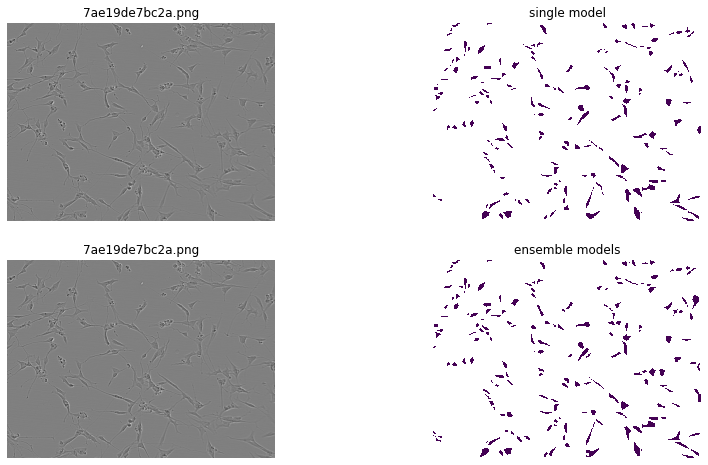

In [11]:
_, axs = plt.subplots(2, 2, figsize=(14, 8))
axs[0][0].imshow(cv2.imread(f'{SUBM_PATH}/{test_names[ID_TEST]}'))
axs[0][0].axis('off')
axs[0][0].set_title(test_names[ID_TEST])
for en_mask in encoded_masks_single:
    dec_mask = rle_decode(en_mask)
    axs[0][1].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
    axs[0][1].axis('off')
    axs[0][1].set_title('single model')
axs[1][0].imshow(cv2.imread(f'{SUBM_PATH}/{test_names[ID_TEST]}'))
axs[1][0].axis('off')
axs[1][0].set_title(test_names[ID_TEST])
for en_mask in encoded_masks:
    dec_mask = rle_decode(en_mask)
    axs[1][1].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
    axs[1][1].axis('off')
    axs[1][1].set_title('ensemble models')
plt.show()

## Inference

In [12]:
# import json
# with open("/kaggle/input/sartorius-coco-dataset-notebook/val_dataset.json") as f:
#     val_data = json.load(f)

    
# val_file_name = []
# for i in range(len(val_data['images'])):
#     val_file_name.append("/kaggle/" + val_data['images'][i]['file_name'][3:-1]+'g')
    
# val_file_name = sorted(val_file_name)

In [13]:
subm_ids, subm_masks = [], []
for test_name in tqdm(test_names):
    if SINGLE_MODE:
        encoded_masks = pred_masks(
            test_name, 
            path=SUBM_PATH, 
            model=MODELS[0],
            ths=THSS[0],
            min_pixels=MIN_PIXELS
        )
    else:
        classes, scores, bboxes, masks = ensemble_preds(
            file_name=test_name, 
            path=SUBM_PATH, 
            models=MODELS, 
            ths=THSS
        )
        if NMS:
            classes, scores, masks = nms_predictions(
                classes, 
                scores, 
                bboxes, 
                masks, 
                iou_th=IOU_TH
            )
        encoded_masks = ensemble_pred_masks(
            masks, 
            classes, 
            min_pixels=MIN_PIXELS
        )
    for enc_mask in encoded_masks:
        subm_ids.append(test_name[:test_name.find('.')])
        subm_masks.append(enc_mask)

  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
nmw_df = pd.DataFrame({
    'id': subm_ids, 
    'predicted': subm_masks
})

# NMS:

In [15]:
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) 
                       for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def pred_masks(file_name, path, model, ths, min_pixels):
    img = cv2.imread(f'{path}/{file_name}')
    output = model(img)
    pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
    pred_class = max(set(pred_classes), key=pred_classes.count)
    take = output['instances'].scores >= ths[pred_class]
    pred_masks = output['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    result = []
    used = np.zeros(img.shape[:2], dtype=int) 
    for i, mask in enumerate(pred_masks):
        mask = mask * (1 - used)
        if mask.sum() >= min_pixels[pred_class]:
            used += mask
            result.append(rle_encode(mask))
    return result

def ensemble_preds(file_name, path, models, ths):
    img = cv2.imread(f'{path}/{file_name}')
    classes = []
    scores = []
    bboxes = []
    masks = []
    for i, model in enumerate(models):
        output = model(img)
        pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
        pred_class = max(set(pred_classes), key=pred_classes.count)
        take = output['instances'].scores >= ths[i][pred_class]
        classes.extend(output['instances'].pred_classes[take].cpu().numpy().tolist())
        scores.extend(output['instances'].scores[take].cpu().numpy().tolist())
        bboxes.extend(output['instances'].pred_boxes[take].tensor.cpu().numpy().tolist())
        masks.extend(output['instances'].pred_masks[take].cpu().numpy())
    assert len(classes) == len(masks) , 'ensemble lenght mismatch'
    #scores, classes, bboxes, masks = zip(*sorted(zip(scores, classes, bboxes, masks),reverse=True))
    return classes, scores, bboxes, masks

def nms_predictions(classes, scores, bboxes, masks, 
                    iou_th=.5, shape=(520, 704)):
    he, wd = shape[0], shape[1]
    boxes_list = [[x[0] / wd, x[1] / he, x[2] / wd, x[3] / he]
                  for x in bboxes]
    scores_list = [x for x in scores]
    labels_list = [x for x in classes]
    nms_bboxes, nms_scores, nms_classes = nms(
        boxes=[boxes_list], 
        scores=[scores_list], 
        labels=[labels_list], 
        weights=None,
        iou_thr=iou_th
    )
    nms_masks = []
    for s in nms_scores:
        nms_masks.append(masks[scores.index(s)])
    nms_scores, nms_classes, nms_masks = zip(*sorted(zip(nms_scores, nms_classes, nms_masks), reverse=True))
    return nms_classes, nms_scores, nms_masks

def ensemble_pred_masks(masks, classes, min_pixels, shape=(520, 704)):
    result = []
    pred_class = max(set(classes), key=classes.count)
    used = np.zeros(shape, dtype=int) 
    for i, mask in enumerate(masks):
        mask = mask * (1 - used)
        if mask.sum() >= min_pixels[pred_class]:
            used += mask
            result.append(rle_encode(mask))
    return result


In [16]:
subm_ids, subm_masks = [], []
for test_name in tqdm(test_names):
    if SINGLE_MODE:
        encoded_masks = pred_masks(
            test_name, 
            path=SUBM_PATH, 
            model=MODELS[0],
            ths=THSS[0],
            min_pixels=MIN_PIXELS
        )
    else:
        classes, scores, bboxes, masks = ensemble_preds(
            file_name=test_name, 
            path=SUBM_PATH, 
            models=MODELS, 
            ths=THSS
        )
        if NMS:
            classes, scores, masks = nms_predictions(
                classes, 
                scores, 
                bboxes, 
                masks, 
                iou_th=IOU_TH
            )
        encoded_masks = ensemble_pred_masks(
            masks, 
            classes, 
            min_pixels=MIN_PIXELS
        )
    for enc_mask in encoded_masks:
        subm_ids.append(test_name[:test_name.find('.')])
        subm_masks.append(enc_mask)

  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
nms_df = pd.DataFrame({
    'id': subm_ids, 
    'predicted': subm_masks
})


# ensemble of ensemble:

In [18]:
def rle_decode1(mask_rle, shape=(520,704,1), color=1):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)
    

def build_masks(image_id, df, input_shape=(520,704), colors=False):
    height, width = input_shape
    labels = df[df["id"] == image_id]["predicted"].tolist()
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode1(label, shape=(height,width , 3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode1(label, shape=(height, width, 1))
    mask = mask.clip(0, 1)
    return mask

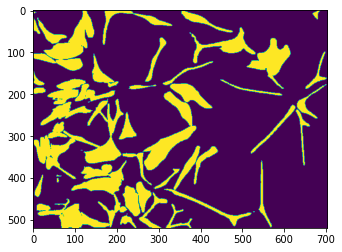

In [19]:
test_ids = list(np.unique(nms_df['id']))
nms_pred_mask = []
for ids in test_ids:
    mask1 = build_masks(ids,nms_df)
    nms_pred_mask.append(mask1)
    
nmw_pred_mask = []
for ids in test_ids:
    mask2 = build_masks(ids,nmw_df)
    nmw_pred_mask.append(mask2)
    
plt.imshow(nmw_pred_mask[2])

In [20]:
# len(nms_pred_mask)

In [21]:
final_pred_mask = [] 
for i in range(3):
    dest_and = cv2.bitwise_and(nmw_pred_mask[i], nms_pred_mask[i], mask = None)
    final_pred_mask.append(dest_and)

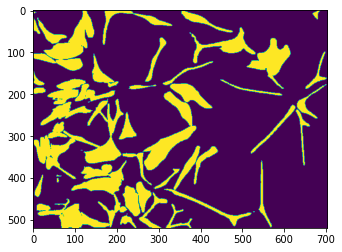

In [22]:
plt.imshow(final_pred_mask[2])

In [23]:
final_pred_mask[2].shape

(520, 704)

In [24]:
def post_process(probability, threshold=0.5, min_size=300):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = []
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            a_prediction = np.zeros((520, 704), np.float32)
            a_prediction[p] = 1
            predictions.append(a_prediction)
    return predictions

In [25]:
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

In [26]:
id_test = []
rle_test = []
for i in range(3):
    post_pro = post_process(final_pred_mask[i])
    for j in post_pro:
        id_test.append(test_ids[i])
        rle_test.append(rle_encoding(j))

In [27]:
pd.DataFrame({
    'id': id_test, 
    'predicted': rle_test
}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()

,id,predicted
0,7ae19de7bc2a,63 11 763 15 1456 2 1459 22 2160 25 2864 24 35...
1,7ae19de7bc2a,276 4 980 6 1684 9 2388 12 3093 13 3798 14 450...
2,7ae19de7bc2a,522 10 1206 7 1225 11 1907 12 1928 13 2610 14 ...
3,7ae19de7bc2a,564 11 581 8 1272 16 1290 3 1978 18 2682 18 33...
4,7ae19de7bc2a,9116 4 9820 5 10523 7 11226 9 11929 11 12632 1...


In [28]:
# pred_mask1 = post_process(final_pred_mask[2])
# plt.imshow(pred_mask1[0])

In [29]:


# rle = rle_encoding()
# pred_mask1 = post_process(final_pred_mask[2])
# p
# plt.imshow(rle_decode1(rle))

In [30]:
# def rles_to_mask(encs, shape=(520,704)):
#     img = np.zeros(shape[0] * shape[1], dtype=np.uint)
#     if type(encs)==float:
#         return img
#     for m, enc in enumerate(encs):
#         if isinstance(enc, np.float) and np.isnan(enc):
#             continue
#         enc_split = enc.split()
#         for i in range(len(enc_split) // 2):
#             start = int(enc_split[2 * i]) - 1
#             length = int(enc_split[2 * i + 1])
#             img[start: start + length] = 1 + m
#     return img.reshape(shape)

In [31]:
# subm_only_ids = [i.split('/')[-1] for i in subm_ids]
# # len(np.unique(subm_only_ids))
# subm_only_ids[0]

In [32]:
# train_csv = "../input/sartorius-cell-instance-segmentation/train.csv"
# df = pd.read_csv(train_csv)

# gt_rle = []

# for i in val_file_name:
#     image_id = i.split('/')[-1].split('.')[0]
#     labels = df[df["id"] == image_id]["annotation"].tolist()
#     gt_rle.append(labels)

In [33]:
# labels = df[df["id"] == image_id]["annotation"].tolist()
# plt.imshow(rles_to_mask(labels))

In [34]:
# val_df = pd.DataFrame({
#     'id': subm_only_ids, 
#     'predicted': subm_masks
# })

# # image_id = '15aeb12e7a83'
# val_labels = val_df[val_df["id"] == image_id]["predicted"].tolist()
# plt.imshow(rles_to_mask(val_labels))
# # len(np.unique(val_df['id'].values))
# # pd.read_csv('submission.csv').head()

In [35]:
# def compute_iou(labels, y_pred):
#     true_objects = len(np.unique(labels))
#     pred_objects = len(np.unique(y_pred))

#     # Compute intersection between all objects
#     intersection = np.histogram2d(
#         labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
#     )[0]

#     # Compute areas (needed for finding the union between all objects)
#     area_true = np.histogram(labels, bins=true_objects)[0]
#     area_pred = np.histogram(y_pred, bins=pred_objects)[0]
#     area_true = np.expand_dims(area_true, -1)
#     area_pred = np.expand_dims(area_pred, 0)

#     # Compute union
#     union = area_true + area_pred - intersection
#     iou = intersection / union
    
#     return iou[1:, 1:]  # exclude background

# def precision_at(threshold, iou):
#     matches = iou > threshold
#     true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
#     false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
#     false_positives = np.sum(matches, axis=0) == 0  # Extra objects
#     tp, fp, fn = (
#         np.sum(true_positives),
#         np.sum(false_positives),
#         np.sum(false_negatives),
#     )
#     return tp, fp, fn

# # def iou_map(truths, preds, verbose=0):
# #     ious = [compute_iou(truth, pred) for truth, pred in zip(truths, preds)]
    
# # #     print(ious[0].shape)

# #     if verbose:
# #         print("Thresh\tTP\tFP\tFN\tPrec.")

# #     prec = []
# #     for t in np.arange(0.5, 1.0, 0.05):
# #         tps, fps, fns = 0, 0, 0
# #         for iou in ious:
# #             tp, fp, fn = precision_at(t, iou)
# #             tps += tp
# #             fps += fp
# #             fns += fn

# #         p = tps / (tps + fps + fns)
# #         prec.append(p)

# #         if verbose:
# #             print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

# #     if verbose:
# #         print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

# #     return np.mean(prec)

# def iou_map(truths, preds, verbose=0):
#     """
#     Computes the metric for the competition.
#     Masks contain the segmented pixels where each object has one value associated,
#     and 0 is the background.

#     Args:
#         truths (list of masks): Ground truths.
#         preds (list of masks): Predictions.
#         verbose (int, optional): Whether to print infos. Defaults to 0.

#     Returns:
#         float: mAP.
#     """
#     ious = [
#         compute_iou(rles_to_mask(truth), rles_to_mask(pred)) 
#             for truth, pred in tqdm(zip(truths, preds))
#     ]
    
#     if verbose:
#         print(ious[0].shape)
#         print("Thresh\tTP\tFP\tFN\tPrec.")

#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         tps, fps, fns = 0, 0, 0
#         for iou in ious:
#             tp, fp, fn = precision_at(t, iou)
#             tps += tp
#             fps += fp
#             fns += fn

#         p = tps / (tps + fps + fns)
#         prec.append(p)

#         if verbose:
#             print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

#     if verbose:
#         print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

#     return np.mean(prec)

In [36]:
# def rle_decode1(mask_rle, shape, color=1):
#     s = mask_rle.split()
#     starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
#     starts -= 1
#     ends = starts + lengths
#     img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
#     for lo, hi in zip(starts, ends):
#         img[lo : hi] = color
#     return img.reshape(shape)
    

# def build_masks(image_id,input_shape=(520,704), colors=False):
#     height, width = input_shape
#     labels = df[df["id"] == image_id]["annotation"].tolist()
#     if colors:
#         mask = np.zeros((height, width, 3))
#         for label in labels:
#             mask += rle_decode1(label, shape=(height,width , 3), color=np.random.rand(3))
#     else:
#         mask = np.zeros((height, width, 1))
#         for label in labels:
#             mask += rle_decode1(label, shape=(height, width, 1))
#     mask = mask.clip(0, 1)
#     return mask

In [37]:
# img_id = '15aeb12e7a83'
# val_pred = val_df[val_df["id"] == img_id]["predicted"].tolist()
# gt_pred = df[df["id"] == img_id]["annotation"].tolist()
# iou_map(gt_pred,val_pred,verbose=1)

In [38]:
# from tqdm import tqdm
# val_map_list = []
# for img_id in tqdm(list(np.unique(subm_only_ids))):
# #     print(img_id)
# #     break
#     val_pred = val_df[val_df["id"] == img_id]["predicted"].tolist()
# #     print(val_pred)
# #     break
#     gt_pred = df[df["id"] == img_id]["annotation"].tolist()
#     print(gt_pred)
#     break
#     val_map_list.append(iou_map(gt_pred,val_pred,verbose=1))


In [39]:
# print(list(np.unique(subm_only_ids)) )
# print([i.split('/')[-1].split('.')[0] for i in val_file_name])
# list(np.unique(subm_only_ids))

In [40]:
# pd.DataFrame({
#     'id': subm_ids, 
#     'predicted': subm_masks
# }).to_csv('submission.csv', index=False)
# pd.read_csv('submission.csv').head()

# References
1. https://www.kaggle.com/vgarshin/detectron2-inference-with-ensemble-and-nms